In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

from keras.models import Sequential, Model
from keras.layers import Conv2D, Dense, Flatten, Activation, MaxPool2D, Cropping2D, Lambda, Dropout

# import shutil
# from os.path import isfile, isdir, getsize
from sklearn.model_selection import train_test_split

from PIL import Image

Using TensorFlow backend.


In [2]:
# df = pd.read_csv('./driving_log.csv', header=None, names=['center', 'left', 'right', 
#                                                           'steering', 'throttle', 'brake', 'speed'])
df = pd.read_csv('./driving_log.csv')
# df.drop(df.columns.values[0], axis=1, inplace=True)
df.center = df.center.str.replace('.*(?=IMG/)', './')
df.left = df.left.str.replace('.*(?=IMG/)', './')
df.right = df.right.str.replace('.*(?=IMG/)', './')

train_df, test_df = train_test_split(df, test_size=0.05, random_state=42)
print(df.shape)
df.head()

(15968, 7)


,center,left,right,steering,throttle,brake,speed
0,./IMG/center_2017_09_17_20_54_28_694.jpg,./IMG/left_2017_09_17_20_54_28_694.jpg,./IMG/right_2017_09_17_20_54_28_694.jpg,0.0,0.0,0.0,0.791958
1,./IMG/center_2017_09_17_20_54_28_774.jpg,./IMG/left_2017_09_17_20_54_28_774.jpg,./IMG/right_2017_09_17_20_54_28_774.jpg,0.0,0.0,0.0,0.784011
2,./IMG/center_2017_09_17_20_54_28_856.jpg,./IMG/left_2017_09_17_20_54_28_856.jpg,./IMG/right_2017_09_17_20_54_28_856.jpg,0.0,0.0,0.0,0.777711
3,./IMG/center_2017_09_17_20_54_28_935.jpg,./IMG/left_2017_09_17_20_54_28_935.jpg,./IMG/right_2017_09_17_20_54_28_935.jpg,0.0,0.0,0.0,0.771461
4,./IMG/center_2017_09_17_20_54_29_012.jpg,./IMG/left_2017_09_17_20_54_29_012.jpg,./IMG/right_2017_09_17_20_54_29_012.jpg,0.0,0.0,0.0,0.766807


In [4]:
# files = df.center.values
# len_files = len(files)
img_height = 160
img_width = 320
channels = 3

# imgs = np.zeros((len_files, img_height, img_width, channels))

# for i, f in enumerate(files):
#     imgs[i] = np.asarray(Image.open(f))
    
# imgs = np.vstack([imgs, imgs[:,:,::-1,:]])
# steering_angle = np.hstack([df.steering.values, -df.steering.values])

def get_batch(df, batch_size=128):
    df.reset_index(inplace=True)
    df = df.loc[np.random.permutation(len(df)), :] # shuffle the data
    k = 0
    files = df.center.values
    len_files = len(files)
    
    while(1):
        # Allocate memory for batch
        imgs = np.zeros((batch_size, img_height, img_width, channels))
        steering_angle = np.zeros((batch_size, 1))
        # get the batch
#         idx = np.random.choice(len_files, batch_size, replace=False)
        for i in range(batch_size):
            imgs[i] = np.asarray(Image.open(files[k]))
            steering_angle[i] = df.steering.values[k]
            k += 1
            if k == len_files:
                k = 0
        imgs = np.vstack([imgs, imgs[:,:,::-1,:]])
        steering_angle = np.vstack([steering_angle, -steering_angle])
        yield imgs, steering_angle

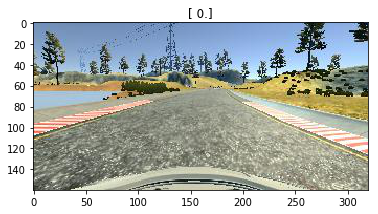

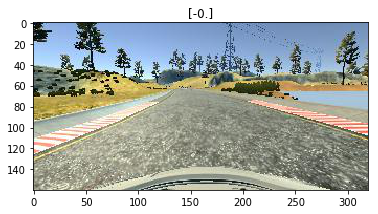

In [5]:
data_gen = get_batch(train_df)
x, y = next(data_gen)

idx = 50
plt.figure()
plt.imshow(x[idx]/255)
plt.title(y[idx])
plt.show
plt.figure()
plt.imshow(x[len(x)//2+idx]/255)
plt.title(y[len(x)//2+idx])
plt.show()

In [6]:
model = Sequential()

# model add LAmbda layer
model.add(Lambda(lambda x: x/255 - 0.5, input_shape = (img_height, img_width, channels)))
model.add(Cropping2D(cropping=((70, 25), (0, 0))))
model.add(Conv2D(8, kernel_size=(3,3), padding='same', activation='relu'))
model.add(Conv2D(8, kernel_size=(3,3), padding='same', activation='relu'))
model.add(MaxPool2D(pool_size=(3, 3)))

model.add(Conv2D(16, kernel_size=(3,3), padding='same', activation='relu'))
model.add(Conv2D(16, kernel_size=(3,3), padding='same', activation='relu'))
model.add(MaxPool2D(pool_size=(3, 3)))

model.add(Conv2D(32, kernel_size=(3,3), padding='same', activation='relu'))
model.add(Conv2D(32, kernel_size=(3,3), padding='same', activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Conv2D(64, kernel_size=(3,3), padding='same', activation='relu'))
model.add(Conv2D(64, kernel_size=(3,3), padding='same', activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(1, activation='tanh'))
model.compile(optimizer='rmsprop', loss='mse')

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_1 (Lambda)            (None, 160, 320, 3)       0         
_________________________________________________________________
cropping2d_1 (Cropping2D)    (None, 65, 320, 3)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 65, 320, 8)        224       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 65, 320, 8)        584       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 21, 106, 8)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 21, 106, 16)       1168      
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 21, 106, 16)       2320      
__________

In [7]:
epochs = 3
batch_size = 128
trainDataGen = get_batch(train_df, batch_size=batch_size)
testDataGen = get_batch(test_df, batch_size=batch_size)

for i in range(epochs):
    model.fit_generator(trainDataGen, steps_per_epoch=len(train_df)//batch_size)
    # Validation loss:
    print(model.evaluate_generator(testDataGen, steps=len(test_df)//batch_size))

Epoch 1/1
118/118 [==============================] - 453s - loss: 0.0613   
0.0605116765946
Epoch 1/1
118/118 [==============================] - 428s - loss: 0.0523   
0.0573168409367
Epoch 1/1
118/118 [==============================] - 379s - loss: 0.0493   
0.0554503519088


In [8]:
model.save('model.h5')

In order to make a video 

In [ ]:
!docker run -it --rm -p 4567:4567 -v `pwd`:/src udacity/carnd-term1-starter-kit python video.py run2